<a href="https://colab.research.google.com/github/yeshdeepak/ImageCaptioning/blob/master/image_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import required libraries

In [3]:
import tensorflow as tf
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt
# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle


Mount your google drive in Collab

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Download Annotations Folder to your google drive

In [5]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists('/content/gdrive/My Drive/Colab Notebooks' + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir='/content/gdrive/My Drive/Colab Notebooks',
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)
else:
  annotation_file = '/content/gdrive/My Drive/Colab Notebooks/annotations/captions_train2014.json'




Retrieve all Image Ids for Vehicle Category from COCO Data Set


In [6]:
from pycocotools.coco import COCO
coco = COCO('/content/gdrive/My Drive/Colab Notebooks/annotations/instances_train2014.json')
catIds = coco.getCatIds(catNms=['person'])
# Get the corresponding image ids and images using loadImgs
imgIds = coco.getImgIds(catIds=catIds)
images = coco.loadImgs(imgIds)


loading annotations into memory...
Done (t=12.30s)
creating index...
index created!


Download all Images from Person Category to Seperate Folder


In [7]:
# Download image files
image_folder = '/train2014'
if not os.path.exists( '/content/gdrive/My Drive/Colab Notebooks'+ image_folder):
   os.mkdir('/content/gdrive/My Drive/Colab Notebooks'+ image_folder)
   images = images[0:1000]
   image_id=[]
   for img in images:
     imageid=img['id']
     url=img['coco_url']
     filename=img['file_name']
     image_id.append(imageid)

     image_zip = tf.keras.utils.get_file(filename,
                                      cache_subdir='/content/gdrive/My Drive/Colab Notebooks/train2014',
                                      origin = url,
                                      extract = True)
     PATH = os.path.dirname(image_zip) +"/"
      
else:
    images = images[0:1000]
    image_id=[]
    for img in images:
      imageid=img['id']
      url=img['coco_url']
      filename=img['file_name']
      image_id.append(imageid)
      PATH = '/content/gdrive/My Drive/Colab Notebooks/train2014/'
 

Store all the Labels and Image name in the form of Vectors.

In [8]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []
for img in image_id:
  for annot in annotations['annotations']:
    if img == annot['image_id']:
       caption = '<start> ' + annot['caption'] + ' <end>'
       #caption =  annot['caption'] 
       image_id = annot['image_id']
       full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)
       all_img_name_vector.append(full_coco_image_path)
       all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
img_name_train = all_img_name_vector[0:4499]
cap_train = all_captions[0:4499]
img_name_val = all_img_name_vector[4500:4999]
cap_val = all_captions[4500:4999]





Store the Images and Captions to Image_Captioning.csv

In [9]:
import pandas as pd
persondata = pd.DataFrame({ "Image" : all_img_name_vector,"Captions" : all_captions,})
persondata=persondata.sort_values(by=['Image', 'Captions'])
persondata.to_csv("/content/gdrive/My Drive/Colab Notebooks/Image_Captioning.csv", index=False)


Split the Data into Training, Validation and Testing Data Set with 80%,10%,10% respectively.

In [10]:
# Create training and validation sets using an 80-20 split

#train_ratio = 0.80
#validation_ratio = 0.10
#img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,train_captions, test_size=1 - train_ratio)


Load the Training, Testing and Validation Data Set in a csv file

In [11]:
import pandas as pd
traindata = pd.DataFrame({ "Image" : img_name_train,"Captions" : cap_train,})
traindata=traindata.sort_values(by=['Image', 'Captions'])
traindata.to_csv("/content/gdrive/My Drive/Colab Notebooks/Image_Captioning_train.csv", index=False)
valdata = pd.DataFrame({ "Image" : img_name_val,"Captions" : cap_val, })
valdata=valdata.sort_values(by=['Image', 'Captions'])
valdata.to_csv("/content/gdrive/My Drive/Colab Notebooks/Image_Captioning_validation.csv", index=False)



Preprocess the images using InceptionV3
Resizing the image to 299px by 299px


In [12]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path


Initialize InceptionV3 and load the pretrained Imagenet weights

In [13]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


87916544/87910968 [==============================] - 1s 0us/step


In [14]:
!pip install -q tqdm
from tqdm import tqdm




Caching the features extracted from InceptionV3

In [15]:
# Get unique images
encode_train = sorted(set(img_name_train))
# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)
for img, path in tqdm(image_dataset):

  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())


100%|██████████| 57/57 [04:22<00:00,  4.60s/it]


Preprocess and tokenize the captions

In [16]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)


In [17]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(cap_train)
train_seqs = tokenizer.texts_to_sequences(cap_train)



In [18]:
def tokenize(word):
    # use real logic here
    return word



In [19]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(cap_train)
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)



In [20]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)


(4499, 4499, 499, 499)

Create a tf.data dataset for training

In [21]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64


In [22]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap


In [23]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_vector))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
You squash that to a shape of (64, 2048).
This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
The RNN (here GRU) attends over the image to predict the next word.


In [24]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


In [25]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


In [26]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [27]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)


In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


In [29]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [30]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)


In [31]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []


In [32]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss


In [33]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 2.1160
Epoch 1 Loss 1.423041
Time taken for 1 epoch 71.78651213645935 sec

Epoch 2 Batch 0 Loss 1.2652
Epoch 2 Loss 1.186483
Time taken for 1 epoch 14.606194972991943 sec

Epoch 3 Batch 0 Loss 1.0679
Epoch 3 Loss 1.038776
Time taken for 1 epoch 13.650702238082886 sec

Epoch 4 Batch 0 Loss 1.0210
Epoch 4 Loss 0.939605
Time taken for 1 epoch 14.023812532424927 sec

Epoch 5 Batch 0 Loss 0.9549
Epoch 5 Loss 0.854218
Time taken for 1 epoch 13.47411036491394 sec

Epoch 6 Batch 0 Loss 0.7864
Epoch 6 Loss 0.788631
Time taken for 1 epoch 14.31080150604248 sec

Epoch 7 Batch 0 Loss 0.7316
Epoch 7 Loss 0.729473
Time taken for 1 epoch 14.04964017868042 sec

Epoch 8 Batch 0 Loss 0.6441
Epoch 8 Loss 0.679988
Time taken for 1 epoch 13.888096570968628 sec

Epoch 9 Batch 0 Loss 0.6549
Epoch 9 Loss 0.635566
Time taken for 1 epoch 14.472047328948975 sec

Epoch 10 Batch 0 Loss 0.5874
Epoch 10 Loss 0.591295
Time taken for 1 epoch 14.173993587493896 sec

Epoch 11 Batch 0 Loss 0.5760
Epo

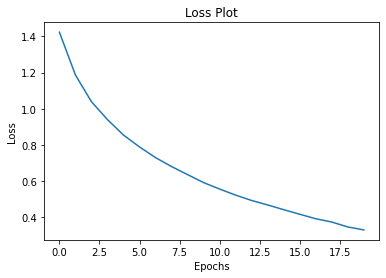

In [34]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()


The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
Stop predicting when the model predicts the end token.
And store the attention weights for every time step.


In [35]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


In [36]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


In [37]:
tokenizer.fit_on_texts(cap_val)
train_seqs = tokenizer.texts_to_sequences(cap_val)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
# Create the tokenized vectors
test_seqs = tokenizer.texts_to_sequences(cap_val)
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_test_vector = tf.keras.preprocessing.sequence.pad_sequences(test_seqs, padding='post')
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(test_seqs )




In [38]:
def get_index_positions(list_of_elems, element):
    index_pos_list = []
    index_pos = 0
    while True:
        try:
            # Search for item in list from indexPos to the end of list
            index_pos = list_of_elems.index(element, index_pos)
            # Add the index position in list
            index_pos_list.append(index_pos)
            index_pos += 1
        except ValueError as e:
            break
    return index_pos_list


In [62]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
valimage_url=[]
valreal_cap=[]
valpred_cap=[]
val_accuracy=[]
with open('/content/gdrive/My Drive/Colab Notebooks/pred_val_results.txt', 'w') as writefile:

 for name in np.unique(img_name_val):
  imageurl="http://images.cocodataset.org/train2014/"+os.path.basename(name)
  print(imageurl)
  image = name
  result, attention_plot = evaluate(image) 
  final_result_1=' '.join(result)
  final_result=[final_result_1]
  predicted_caption = [tokenize(word) for sentence in final_result for word in sentence.split()]
  predicted_caption=predicted_caption
  for val_img_name in img_name_val:
    if name == val_img_name:
      list_real_captions_1=[]
      rc=[]
      rid= get_index_positions(img_name_val,val_img_name)
      for rid in rid:
         real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_vector[rid] if i not in [0]])
         real_caption_1=[real_caption]
         real_caption_1 = [tokenize(word) for sentence in real_caption_1 for word in sentence.split()]
         final_result=[final_result_1]
         length=len(real_caption_1)
         del real_caption_1[length-1] 
         del real_caption_1[0] 
         length=len(predicted_caption)
         #del predicted_caption[length-1] 
         real_captions=real_caption_1
         list_real_captions=real_captions
         list_real_captions_1.append(list_real_captions)
         rc.append(real_caption  ) 
  final_rc = '\n'.join(rc)
       
  print ('Real Caption:', final_rc)
  print ('Predicted Caption:', final_result_1)
  #print(list_real_captions_1)
  #print(predicted_caption)
  accuracy=sentence_bleu(list_real_captions_1, predicted_caption,weights=(0.33,0.33,0.33,0))
  print('BLEU Score: %f'  % sentence_bleu(list_real_captions_1, predicted_caption,weights=(0.33,0.33,0.33,0)))
  print("\n")
  valimage_url.append(imageurl) 
  valreal_cap.append(rc) 
  valpred_cap.append(final_result_1  ) 
  accuracy=str(accuracy)
  val_accuracy.append(accuracy)
  writefile.write(imageurl )
  writefile.write("\n")
  writefile.write("Real Captions:")
  writefile.write("\n")
  writefile.write(final_rc )
  writefile.write("Predicted Caption: " )
  writefile.write("\n")
  writefile.write(final_result_1)
  writefile.write("\n")
  writefile.write("Bleu Score: " )
  writefile.write(accuracy )
  writefile.write("\n")
  writefile.write("\n")







  
 




http://images.cocodataset.org/train2014/COCO_train2014_000000002415.jpg
Real Caption: <start> some people and a brown and white animal and grass <end>
<start> a group of men trying to move an animal <end>
<start> an animal sits on the grass as several people watch <end>
<start> a yak being pulled by the towns people in foreign land <end>
<start> a group of men pull a bovine by its horns <end>
Predicted Caption: a man ted with a glass <end>
BLEU Score: 0.497019


http://images.cocodataset.org/train2014/COCO_train2014_000000002444.jpg


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Real Caption: <start> a large horse is attached to a carriage <end>
<start> a horse pulling a cart near some houses <end>
<start> a team of clydsdales hitched to a carriage in front of a building <end>
<start> two horses strapped to the front of a carriage stop in front of a wooden building <end>
<start> two large draught horses harnessed in to a carriage <end>
Predicted Caption: a bicycle scooter cabinets <end>
BLEU Score: 0.322673


http://images.cocodataset.org/train2014/COCO_train2014_000000002445.jpg
Real Caption: <start> a baseball player swinging a baseball bat over home plate <end>
<start> baseball player preparing to swing his bat at the plate <end>
<start> a baseball game in progress with the pitch in the middle of a swing <end>
<start> a batter swings at the ball as the catcher and umpire watch <end>
<start> a person that is swinging a bat in a baseball game <end>
Predicted Caption: a air her two a ski <end>
BLEU Score: 0.430855


http://images.cocodataset.org/train2014/COCO

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Real Caption: <start> a group of kids play frisbee in a muddy field while it rains <end>
<start> a small group of people are playing frisbee in the mud <end>
<start> a group of four people play frisbee on the beach <end>
<start> a group of people jump to catch a frisbee on the beach <end>
<start> a group of people are outdoors playing with a frisbee in the rain <end>
Predicted Caption: a his of people board at a child of people men resting the frisbee and a his of people an in skateboard of city shown
BLEU Score: 0.230193


http://images.cocodataset.org/train2014/COCO_train2014_000000002536.jpg
Real Caption: <start> several people on surfboards waiting for a good wave <end>
<start> a group of surfers are waiting on the water to catch the next wave <end>
<start> bunch of people out in the water on surfboards waiting for a wave <end>
<start> a group of people are in the ocean on surfboards <end>
<start> surfers paddling into the ocean on their boards <end>
Predicted Caption: a man that i

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Real Caption: <start> a tennis player getting ready to serve the ball <end>
<start> a woman taking a swing at a tennis ball <end>
<start> a girl dressed all in orange hitting a tennis ball <end>
<start> a woman swinging a tennis racquet at a tennis ball <end>
<start> young woman in orange dress about to serve in tennis game on blue court with green sides <end>
Predicted Caption: a man video a tennis about <end>
BLEU Score: 0.345878


http://images.cocodataset.org/train2014/COCO_train2014_000000002563.jpg
Real Caption: <start> people are standing in a field with kites flying above <end>
<start> a person playing with a kite in the middle of a field <end>
<start> a group of people flying kites in a field <end>
<start> people flying kites in an open field on a sunny day <end>
<start> people in a large grassy area flying kites up into the sky <end>
Predicted Caption: frisbee three of a dryer <end>
BLEU Score: 0.248166


http://images.cocodataset.org/train2014/COCO_train2014_000000002567.jpg

188416/187328 [==============================] - 0s 1us/step
Image Url: http://images.cocodataset.org/train2014/COCO_train2014_000000133727.jpg
Predicted Caption: a man skateboarding a petting <end>




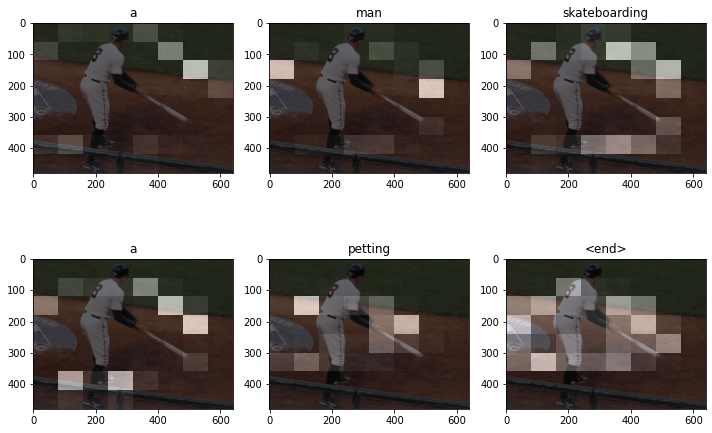

262144/254340 [==============================] - 0s 1us/step
Image Url: http://images.cocodataset.org/train2014/COCO_train2014_000000264567.jpg
Predicted Caption: standing together man in a bed in standing bicycle bed in a bicycle bed in a bicycle bed in a bicycle bed in a bed




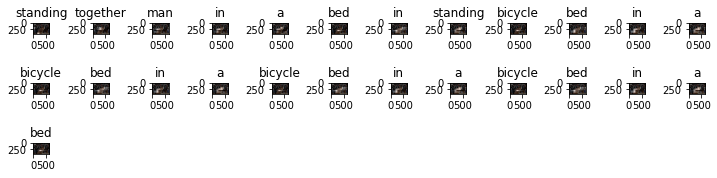

In [51]:
url = ['http://images.cocodataset.org/train2014/COCO_train2014_000000133727.jpg', 
       'http://images.cocodataset.org/train2014/COCO_train2014_000000264567.jpg']
testimage_url=[]
test_pred_cap=[]       
for url in url:
  name=os.path.basename(url)
  image_path= tf.keras.utils.get_file(name,origin=url)
  result, attention_plot_1 = evaluate(image_path)
  print("Image Url:", url)
  print ('Predicted Caption:', ' '.join(result))
  print("\n")
  plot_attention(image_path, result, attention_plot_1)
  pred_cap= ' '.join(result)
  testimage_url.append(url)
  test_pred_cap.append(pred_cap)
testdata = pd.DataFrame({ "Image_url" : testimage_url,"Predicted Captions": test_pred_cap })
testdata=testdata.sort_values(by=['Image_url', 'Predicted Captions'])
testdata.to_csv("/content/gdrive/My Drive/Colab Notebooks/testdata.csv", index=False)


  